In [25]:
import cv2
import numpy as np
import faiss
import os
from deepface import DeepFace
import json

# Load YuNet model for face detection
yunet = cv2.FaceDetectorYN.create(
    model="face_detection_yunet_2023mar.onnx",  # Pre-trained ONNX model path
    config="",
    input_size=(320, 320),  # Input image size
    score_threshold=0.4,
    nms_threshold=0.2,
    top_k=5000
)

# Load FaceNet model for embeddings
facenet_model = "VGG-Face"  # You can also use 'Facenet512' for higher accuracy


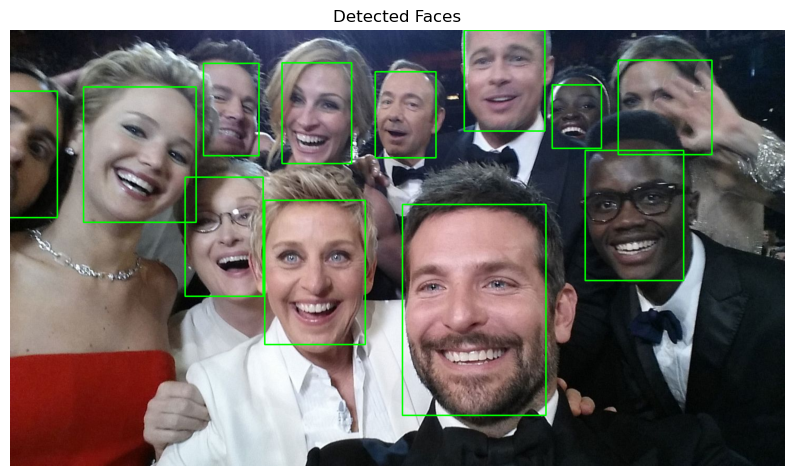

Processed image saved to oscar/detected_faces.jpg


In [28]:
from matplotlib import pyplot as plt
import os

def detect_and_display_faces(image_path, output_path=None):
    """
    Detects faces in the input image, displays the image with bounding boxes in a Jupyter Notebook,
    and optionally saves the processed image to a file.
    
    Args:
        image_path (str): Path to the input image.
        output_path (str, optional): Path to save the processed image. If None, the image won't be saved.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Convert the image to grayscale (required for some detection models)
    height, width, _ = image.shape
    yunet.setInputSize((width, height))

    # Detect faces
    _, faces = yunet.detect(image)

    # Draw bounding boxes around detected faces
    if faces is not None:
        for face in faces:
            x, y, w, h = map(int, face[:4])
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert the image from BGR to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Detected Faces")
    plt.show()

    # Save the processed image if an output path is specified
    if output_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, image)
        print(f"Processed image saved to {output_path}")

# Example usage
detect_and_display_faces(
    "oscar/photos/gettyimages-476996143.jpg", 
    "oscar/detected_faces.jpg"
)


Animated GIF saved to oscar/output_with_faces.gif


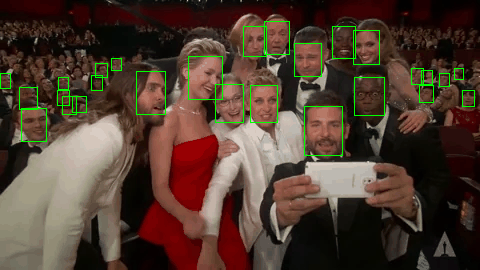

In [27]:
from PIL import Image, ImageSequence
import cv2
import numpy as np
from IPython.display import display, Image as IPImage

def detect_faces_and_save_as_gif(webp_path, output_gif_path):
    """
    Detects faces in each frame of an animated WebP file, saves the processed frames as a GIF, 
    and displays the animation in Jupyter Notebook.

    Args:
        webp_path (str): Path to the animated WebP file.
        output_gif_path (str): Path to save the output GIF.
    """
    try:
        # Open the animated WebP using Pillow
        with Image.open(webp_path) as im:
            processed_frames = []
            durations = []

            for frame in ImageSequence.Iterator(im):
                # Convert the frame to a numpy array
                frame = frame.convert("RGB")  # Convert to RGB
                frame_np = np.array(frame)
                frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)  # Convert to BGR (for OpenCV)

                # Prepare YuNet for detection
                height, width, _ = frame_bgr.shape
                yunet.setInputSize((width, height))

                # Detect faces
                _, faces = yunet.detect(frame_bgr)

                # Draw bounding boxes on detected faces
                if faces is not None:
                    for face in faces:
                        x, y, w, h = map(int, face[:4])
                        cv2.rectangle(frame_bgr, (x, y), (x + w, y + h), (0, 255, 0), 1)

                # Convert back to RGB for saving in GIF
                frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                processed_frame = Image.fromarray(frame_rgb)
                processed_frames.append(processed_frame)

                # Add the duration for the current frame
                durations.append(frame.info.get("duration", 100))  # Default duration is 100ms if not available

            # Save processed frames as an animated GIF
            processed_frames[0].save(
                output_gif_path,
                save_all=True,
                append_images=processed_frames[1:],
                duration=durations,
                loop=0
            )

            print(f"Animated GIF saved to {output_gif_path}")

            # Display the GIF in Jupyter Notebook
            with open(output_gif_path, "rb") as f:
                display(IPImage(f.read()))

    except Exception as e:
        print(f"Error processing WebP file: {e}")


# Example usage
webp_path = "oscar/giphy.webp"  # Replace with the path to your animated WebP
output_gif_path = "oscar/output_with_faces.gif"  # Replace with your desired output path
detect_faces_and_save_as_gif(webp_path, output_gif_path)

